# 4 coloring Problem
* Contains results from running on IBMQ_Paris machine

* Code inspired by https://hal.archives-ouvertes.fr/hal-02891847/document

In [1]:
# 2 color graph coloring problem circuit
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram
import networkx as nx

# Function Definitions

In [2]:
# This function is responsible for looking through the
# edges in the graph and determining the implicit
# constraints between them.
def getImplicitConstraints(graph):
    g = []
    for (u,v) in graph:
        g.append((u,v))
        if (v,u) not in g:
            g.append((v,u))
            
    cmap = dict()
    for (a,b) in g:
        for (c,d) in g:
            u = a; v = b; x = c; y = d
            if (v == x) and (u != y):
                if y <= u:
                    u, y = y, u
                if (u,y) not in g:
                    cmap[(u,y)] = (u,y)
    return list(cmap)

# used check the results and to see if any of the
# outputs contain any pairs of vertices which have
# the same coloring assigned. If so then this function
# return false.
def uniqueCharacters(st, graph):
    # Using sorting
    # sorted(st)
    s = len(st)-1
    for (i,j) in graph:
        if st[s-i] == st[s-j]:
            return False

    return True

# used to extract the color to plot graph with
def getColoring(coloring):
    colorMap = []
    for c in reversed(coloring):
        if c == 'R':
            colorMap.append('Red')
        elif c == 'G':
            colorMap.append('Green')
        elif c == 'B':
            colorMap.append('Blue')
        else:
            colorMap.append('Gray')
    return colorMap

# Preparting graph to converting to circuit

[(0, 1), (0, 2), (1, 3), (2, 3), (3, 4)]


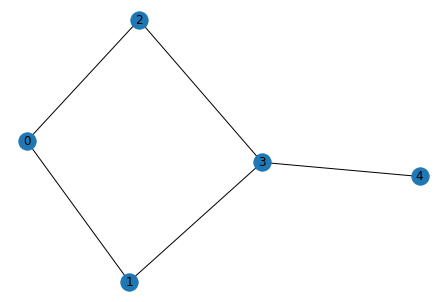

In [3]:
# Define the graph by giving the ends of each edge

g = [(0,1),(0,2),(1,3),(2,3),(3,4)]

nVert = max(max(g))+1
nodes = list(range(nVert))
nEdges = len(g)


# list of all constraints to apply to graph
cg = []
for (v1,v2) in g:
    if v1 < v2:
        cg.append((v1,v2))
    elif v2 < v1:
        cg.append((v2,v1))

# Sort the constraints to ensure the implicit constraints
#   are after the corresponding explicit contraints
# The edges are the explicit constraints and the pair of vertices
#   which have a common neighbour are the implicit constraints.
# Sorting the constraints is import because this will affect the order
#   in which the circuit circuit is constructed.
# Example:
#           g = [(0,1), (1,2)]
# (0,2) is an implicit constraint because we want to maximize the
#   number of colors used so ideally vertices 0 and 2 must have
#   different coloring
# So the constraint graph should be in the orders: cg = [(0,1), (0,2), (1,2)]

print(cg)

# view the graph
ngx = nx.Graph()
for i in g:
    ngx.add_edge(i[0], i[1])
    
nx.draw(ngx, with_labels=True)


In [4]:
# Add additional constraints
# Get the implict constraints between vertices which
# have a common neighbour
cons = getImplicitConstraints(g)
nCons = len(cons)
cg.extend(cons)
cg.sort()
print(cg)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


# Construct circuit with unitary to remove |11> state

In [5]:
ce = 2
# Create a Quantum Circuit
qv = QuantumRegister(ce*nVert)
q = QuantumRegister(4)
c = ClassicalRegister(ce*nVert)
qc = QuantumCircuit(qv,q,c)

# Add the gates to the circuit for each edge in the graph
for i in range(nVert*ce):
    qc.h(i)

# The three transition above create a circular transition when two vertices
#   have the same color/state
# Two |00> vertices cause the second vertex to transition to |01>
#               |00>x|00> ---> |00>x|01>
# Two |01> vertices cause the second vertex to transition to |10>
#               |01>x|01> ---> |01>x|10>
# Two |10> vertices cause the second vertex to transition to |00>
#               |10>x|10> ---> |10>x|11>
# Two |11> vertices causes the second vertex to transition to |00>
#               |11>x|11> ---> |00>x|00>

k = ce*nVert
for edge in cg:
    i = edge[0]*ce
    j = edge[1]*ce

    qc.ccx(i,j,k)
    qc.ccx(i+1,j+1,k+1)

    # check if two states are the same
    qc.x(i)
    qc.x(i+1)
    qc.x(j)
    qc.x(j+1)
    qc.ccx(i,j,k+2)
    qc.ccx(i+1,j+1,k+3)
    qc.x(i)
    qc.x(i+1)
    qc.x(j)
    qc.x(j+1)

    # to transition the |00>x|00> ---> |00>x|01>
    qc.ccx(k+3, k+2, j)

    # to transition the |01>x|01> ---> |01>x|10>
    qc.ccx(k+3,k,j)
    qc.ccx(k+3,k,j+1)

    # to transition the |10>x|10> ---> |10>x|11>
    qc.ccx(k+2,k+1,j)

    # to transition |11>x|11> ---> |11>x|00> 
    qc.ccx(k+1, k, j)
    qc.ccx(k+1, k, j+1)
    
    qc.barrier()

    qc.reset(k)
    qc.reset(k+1)
    qc.reset(k+2)
    qc.reset(k+3)

# measure all the input qubits
qc.measure(qv,c)

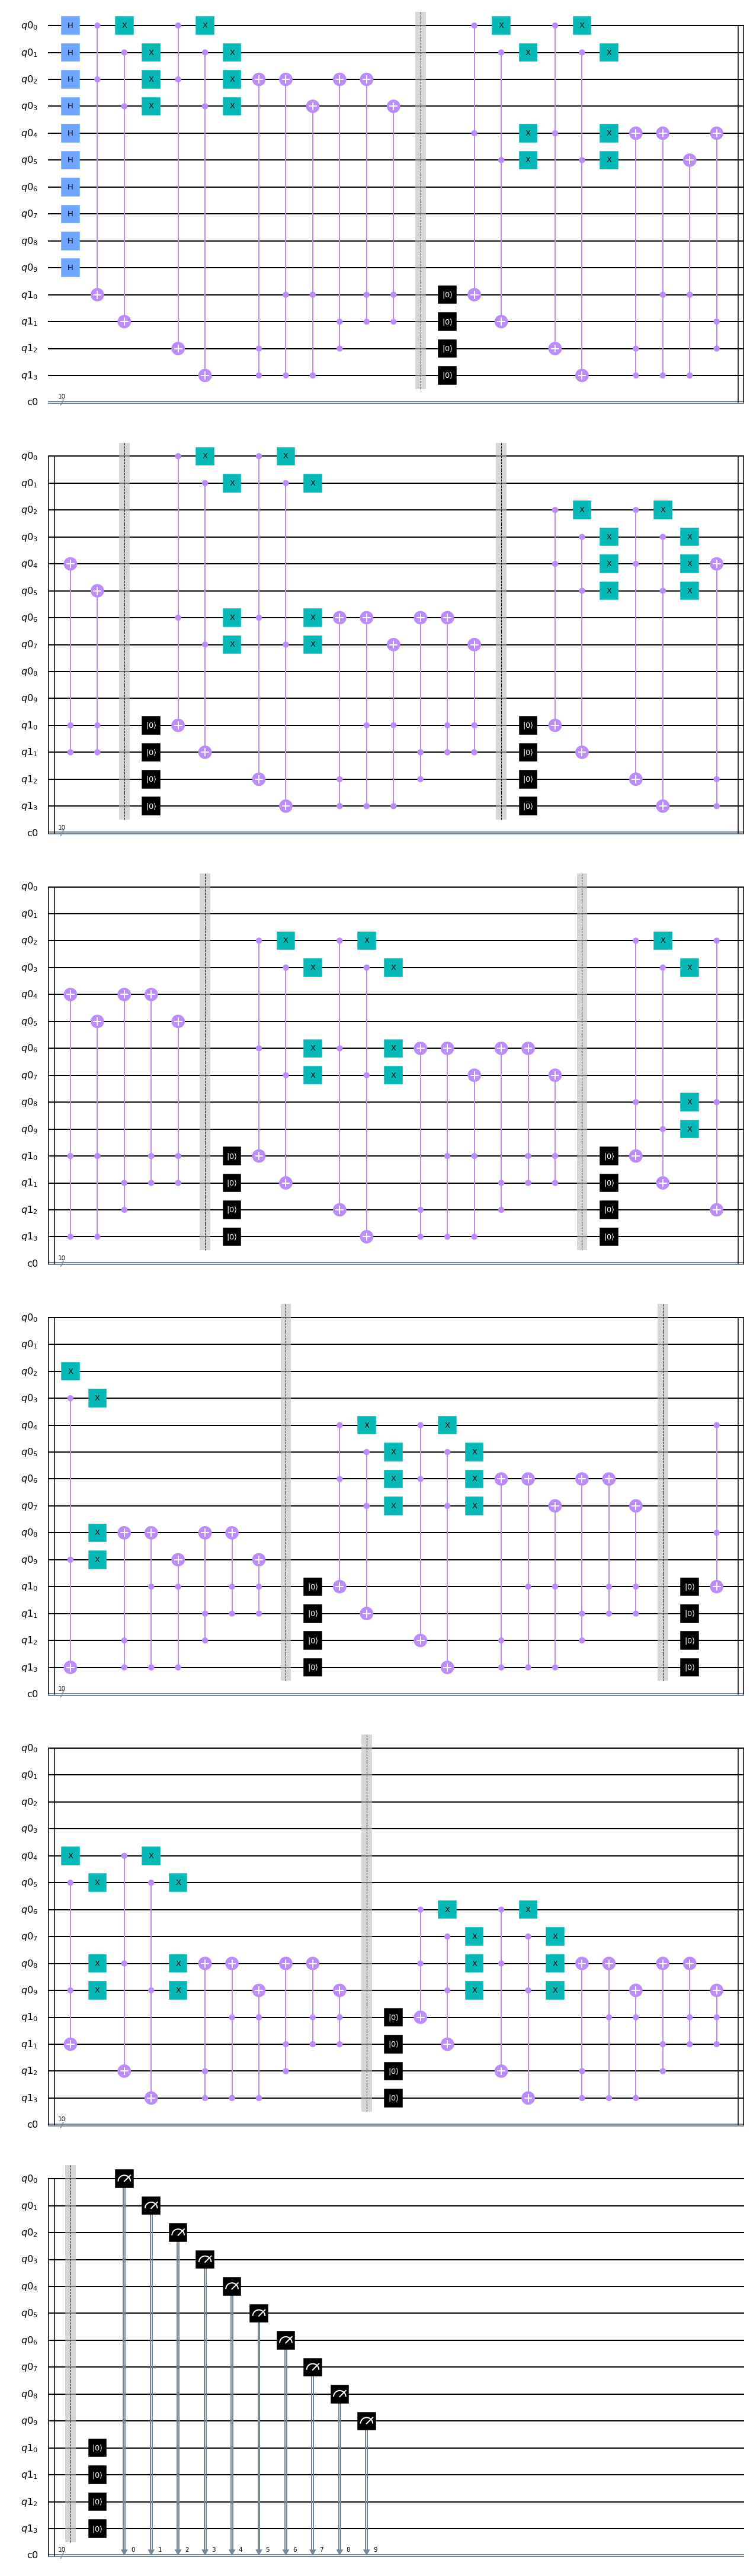

In [6]:
#--------------- Drawing
qc.draw(output='mpl')

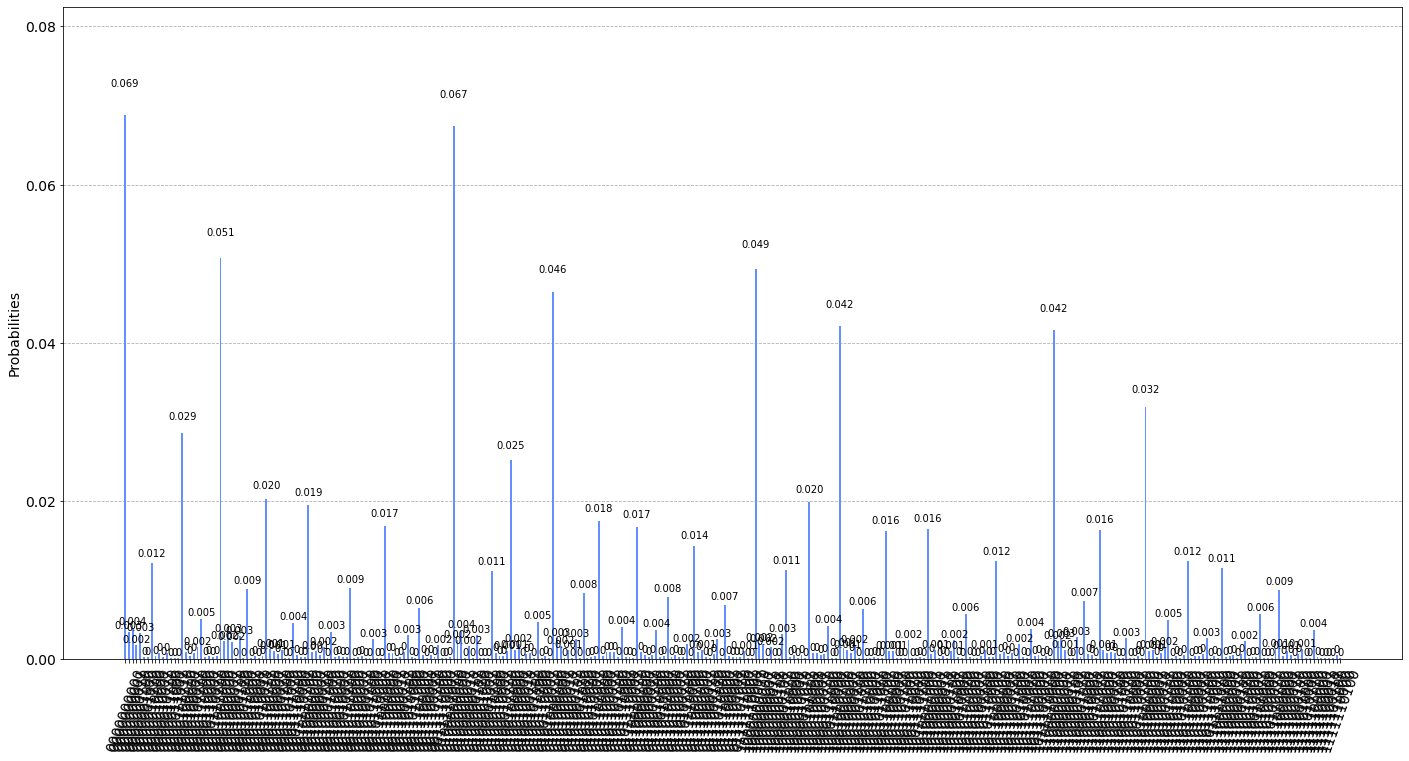

In [7]:
from qiskit import IBMQ
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-ncsu', group='nc-state', project='grad-qc-class')

toronto = provider.get_backend('ibmq_toronto')
paris = provider.get_backend('ibmq_paris')

results = execute(qc, backend=paris, shots=8000).result()
counts = results.get_counts()

plot_histogram(counts, figsize=(24,12))

In [8]:
print(len(counts))

319


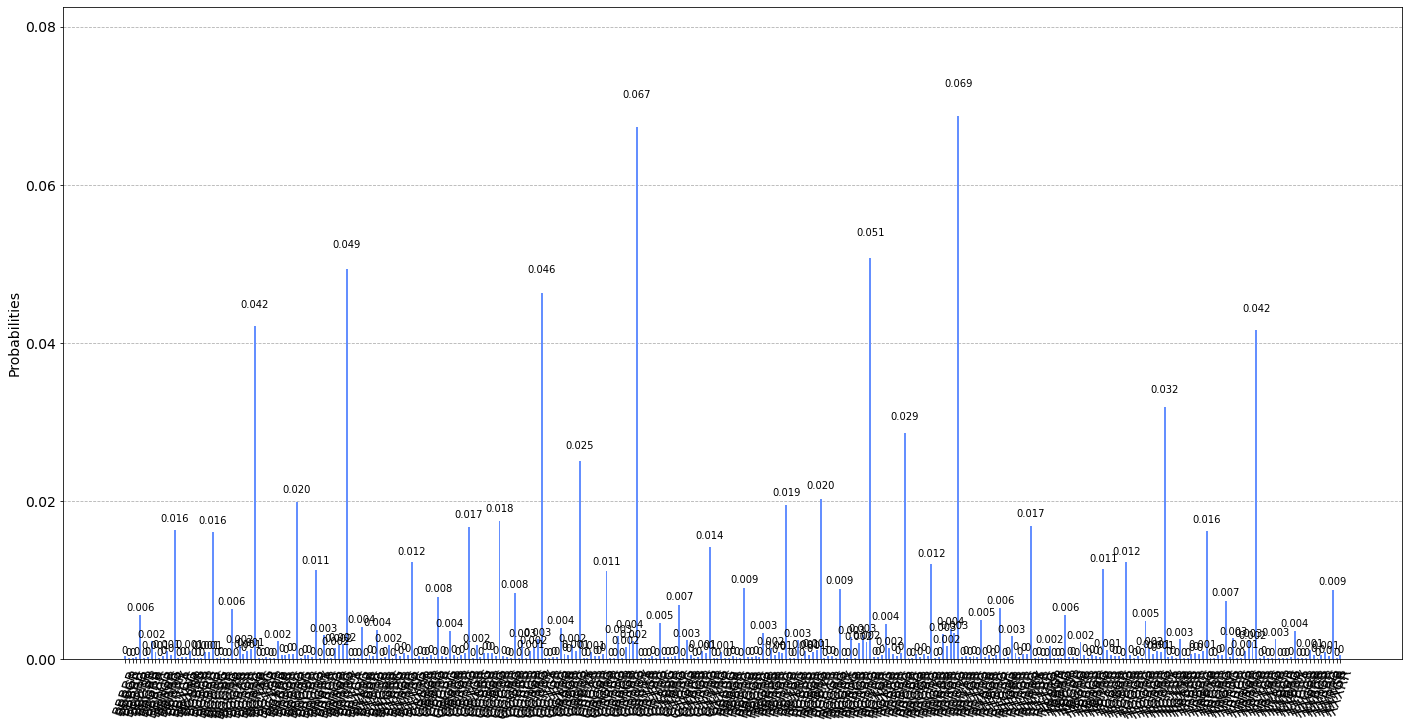

In [9]:
cMap = {'00':'R', '01':'G', '10':'B', '11':'X'}
colorCoded = dict()
colorCoded3 = dict()
for k in counts:
    s = ""
    i = 0
    while i < len(k):
        s += cMap[k[i:i+2]]
        i += 2
    colorCoded[s] = counts[k]
    if uniqueCharacters(s, g):
        colorCoded3[s] = counts[k]

# sort the results to better visualize
colorCoded = {k: v for k, v in sorted(colorCoded.items(), key=lambda item: item[1], reverse=True)}
plot_histogram(colorCoded, figsize=(24,12))

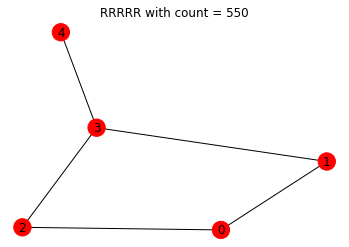

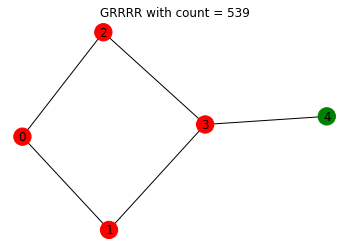

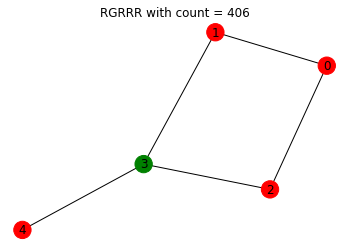

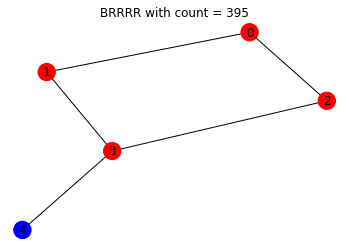

In [10]:
i = 4
for key in colorCoded:
    if i == 0:
        break
    i -= 1
    plt.figure()
    plt.title(key + " with count = " + str(colorCoded[key]))
    colorMap = getColoring(key)
    nx.draw(ngx, node_color=colorMap, with_labels=True)
    

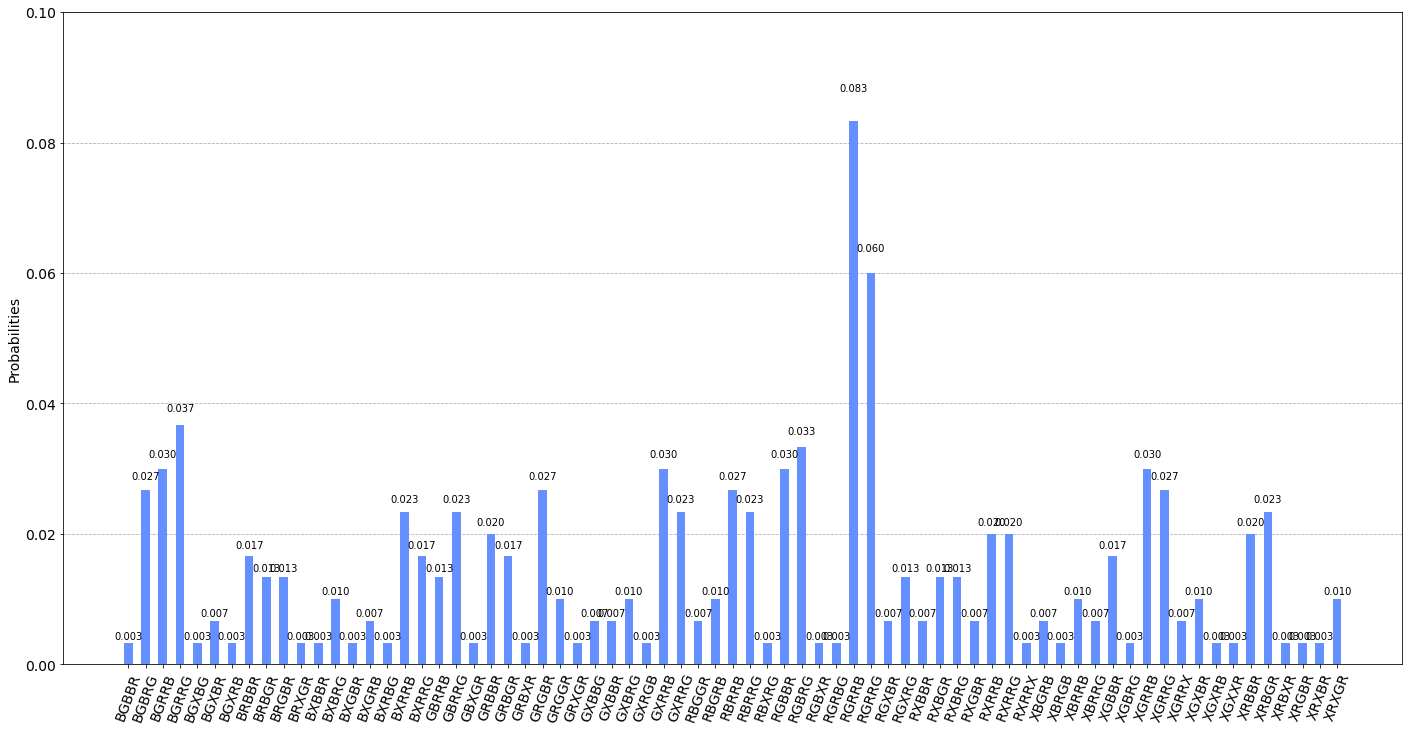

In [11]:
# plot the histogram of the filtered resilts with any results with two
# same colors adjacent to each other are removed.
colorCoded3 = {k: v for k, v in sorted(colorCoded3.items(), key=lambda item: item[1], reverse=True)}
plot_histogram(colorCoded3, figsize=(24,12))

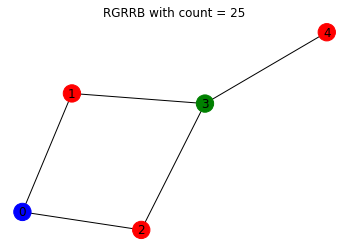

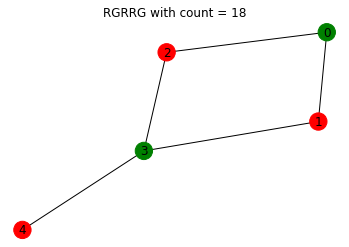

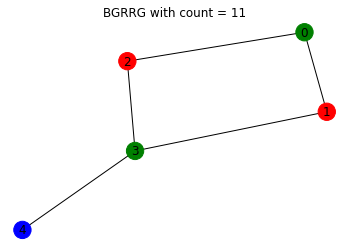

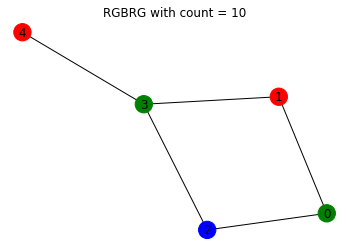

In [12]:
# display the result the highest count in the filtered list of results
i = 4
for key in colorCoded3:
    if i == 0:
        break
    i -= 1
    plt.figure()
    plt.title(key + " with count = " + str(colorCoded3[key]))
    colorMap = getColoring(key)
    nx.draw(ngx, node_color=colorMap, with_labels=True)
    